**Test Version of MaskRCNN for leucocyte detection**

How to use it

step 1:
- Click the 'Run' button under '1. Initialization'
- Allow access to google drive

step 2:
- Copy the path of 'checkpointsXXX.pth' to 'model' filed
- *opt*: Select mask/box to show mask/box in later process
- *opt*: Set threshold.
  A higher threshold leading to a stricter model - less cells will be detected, but more confident
- Click the 'Run' button under '2. Set Parameters'

step 3:
- Copy the path of 'image.png/tif' to 'path' filed
- Select show image to show image after predicting
- Click the 'Run' button under '3. Image upload'

In [9]:
# @title 2. Set parameters
# ------------- Initial user input ------------
model = '/content/drive/MyDrive/model29.pth' #@param {type:"string"}
mask = False #@param {type:"boolean"}
box = True #@param {type:"boolean"}
mask_threshold = 0.8  #@param {type:"number"}
box_threshold = 0.5 #@param {type:"number"}

In [9]:
# @title Additional loop
print('was it correct?\na.yes\nb.no')
a = input()
if a == 'b':
  b = input('what is the correct label?\na.a\nb.b\n')
  c = input('should we retrain it?\n')

was it correct?
a.yes
b.no
b
what is the correct label?
a.a
b.b
a
should we retrain it?
yes


In [5]:
# @title 1. Initialization
import torch
from PIL import Image
from math import ceil
import numpy as np
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import sys
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import maskrcnn_resnet50_fpn
import torchvision
from tqdm import tqdm
import warnings
import os

from google.colab import drive
drive.mount('/content/drive')

warnings.filterwarnings("ignore")

def normalize(data, one = True):
    data = np.array(data)
    min_val = data.min()
    max_val = data.max()

    normalized_img = (data - min_val) / (max_val - min_val)

    if one:
        return normalized_img.astype(np.float32)
    else:
        normalized_img_255 = (normalized_img * 255).astype(np.float32)
        return normalized_img_255

def split_image(image, rows, cols):
    image = Image.fromarray(image)
    images = []

    img_width, img_height = image.size
    width = img_width // cols
    height = img_height // rows

    for i in range(rows):
        for j in range(cols):
            box = (j * width, i * height, (j + 1) * width, (i + 1) * height)
            img = image.crop(box)
            images.append(img)

    return images


def stitch_images(tiles, rows, cols):
    if not tiles:
        raise ValueError("The list of tiles is empty")

    # Assuming all tiles have the same size and number of channels
    tile_height, tile_width, channels = tiles[0].shape

    # Create a new array with the combined size
    stitched_image = np.zeros((tile_height * rows, tile_width * cols, channels), dtype=tiles[0].dtype)

    for i in range(rows):
        for j in range(cols):
            # Calculate the index of the tile
            tile_index = i * cols + j
            if tile_index >= len(tiles):
                raise IndexError("Tile index out of range")

            # Get the current tile
            tile = tiles[tile_index]

            # Calculate where to place the tile in the stitched image
            y_start = i * tile_height
            y_end = y_start + tile_height
            x_start = j * tile_width
            x_end = x_start + tile_width

            # Place the tile
            stitched_image[y_start:y_end, x_start:x_end, :] = tile

    return stitched_image


label_map = {
    'above' : 1,
    'endothelial': 0,
    'under' : 3,
    'tem' : 2,
    'ab' : 1,
    'un' : 3,
    'mid' : 2,
    'endo' :0
}

def maskmodel(num):
    model = maskrcnn_resnet50_fpn()

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = torchvision.models.detection.mask_rcnn.MaskRCNNPredictor(in_features_mask, hidden_layer, num)
    return model

colormap = { #BGR
    0 : [255, 255, 255],
    1:[0, 255, 0], #green above
    2:[0, 0, 255], #Red tem
    4:[255, 255, 0],
    3:[255, 0, 0] #Blue under
}

def load_and_preprocess_image(img):
    img = np.array(img)
    if len(img.shape) == 2:
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)  #H x W x C
    elif img.shape[2] == 4:
        img = img[:, :, :3]
    # print(f'max: {np.max(img)}, min: {np.min(img)}, shape: {img.shape}')

    img_tensor = torch.from_numpy(np.array(img.copy(), dtype=np.float32)).contiguous()
    img_tensor = img_tensor.permute(2, 0, 1)
    return img_tensor, img

def predict_image(image, net, device, tmask = 0.5, tbox = 0.7, showmask=False, showbox=True, replace = False):
    net.eval()
    # device = torch.device("mps" if torch.cuda.is_available() else "cpu") if device is None else device
    net.to(device)

    img_tensor, image = load_and_preprocess_image(image)
    img_tensor = img_tensor.to(device).unsqueeze(0)

    with torch.no_grad():
        output = net(img_tensor)

    masks = output[0]['masks'].cpu().numpy()
    boxes = output[0]['boxes'].cpu().numpy()
    labels = output[0]['labels'].cpu().numpy()
    scores = output[0]['scores'].cpu().numpy()

    indexes = np.where(scores > tbox)[0]
    boxes = boxes[indexes]
    masks = masks[indexes]
    labels = labels[indexes]
    scores = scores[indexes]

    for mask, box, label in zip(masks, boxes, labels):
        if showbox:
            cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), colormap[label], 1)

        # Threshold the mask
        thresholded_mask = mask[0] > tmask
        if showmask:
          if replace:
              # Create a mask overlay
              colored_mask = np.zeros_like(image, np.uint8)
              colored_mask[thresholded_mask] = colormap[label]
              image = cv2.addWeighted(image, 1.0, colored_mask, 0.5, 0)
          else:
              # Directly replace the color in the mask area
              color = np.array(colormap[label])
              alpha = 0.05
              image[thresholded_mask] = alpha * color + (1 - alpha) * image[thresholded_mask]

    return image, masks, boxes, labels

def predict(image, point = 'checkpoint_epoch_29.pth', tmask = 0.5, tbox = 0.7, mask = False, box = True): #43:88-22; 30:1010-66; 29:1010-22
    model = maskmodel(4)
    model.load_state_dict(torch.load(point, map_location=torch.device('cuda')))

    image = normalize(np.array(image))

    col = ceil(image.shape[1]/350)
    row = ceil(image.shape[0]/250)

    images = split_image(image,row, col)
    outimages = []
    labels = []
    i = 3
    for i, image in enumerate(tqdm(images, desc="Processing images",leave=False), start=1):
        outimg, masks, boxes, label = predict_image(image, model, 'cuda', tmask, tbox, mask, box)
        outimages.append(outimg)
        labels += label.tolist()

    image = stitch_images(outimages,row, col)
    aboves = labels.count(1)
    unders = labels.count(3)
    tems = labels.count(2)

    return image, aboves, tems, unders



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# @title 3. Image upload
# ------------- Initial user input ------------
path = '/content/drive/MyDrive/small.tif' #@param {type:"string"}
show_images = False #@param {type:"boolean"}
show_counts = True #@param {type:"boolean"}

import tifffile as tiff

multi = False
if path.split('.')[-1] == 'tif':
    img = tiff.TiffFile('/content/drive/MyDrive/small.tif').asarray()
else:
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)

if len(img.shape) == 3:
    multi = True
    aboves, tems, unders = [],[],[]
    for t in range(img.shape[0]):
        frame = img[t, :, :]
        processed_image, above, tem, under = predict(image = frame, point = model, tmask = mask_threshold, tbox = box_threshold, mask = mask, box = box)
        aboves.append(above)
        tems.append(tem)
        unders.append(under)
        if show_images:
            plt.imshow(processed_image)
            plt.axis('off')  # To turn off axis
            plt.show()
        if show_counts:
            print(f'frame: {t+1}/{img.shape[0]} above: {above} tem:{tem} under: {under}')
elif len(img.shape) == 2:
    processed_image, above, tem, under = predict(image = img, point = model, tmask = mask_threshold, tbox = box_threshold, mask = mask, box = box)
    if show_images:
        plt.imshow(processed_image)
        plt.axis('off')  # To turn off axis
        plt.show()
    if show_counts:
        print(f'above: {above}\ntem:{tem}\nunder: {under}')

In [45]:
# @title 4. To CSV(optional)
import pandas as pd

if multi:
    df = pd.DataFrame({
        'above': aboves,
        'tem': tems,
        'under': unders
    })
    df.index = [f'frame_{i}' for i in range(len(df))]

    df.to_csv('/content/results.csv')
else:
    print('image does not have mutiple time frame')

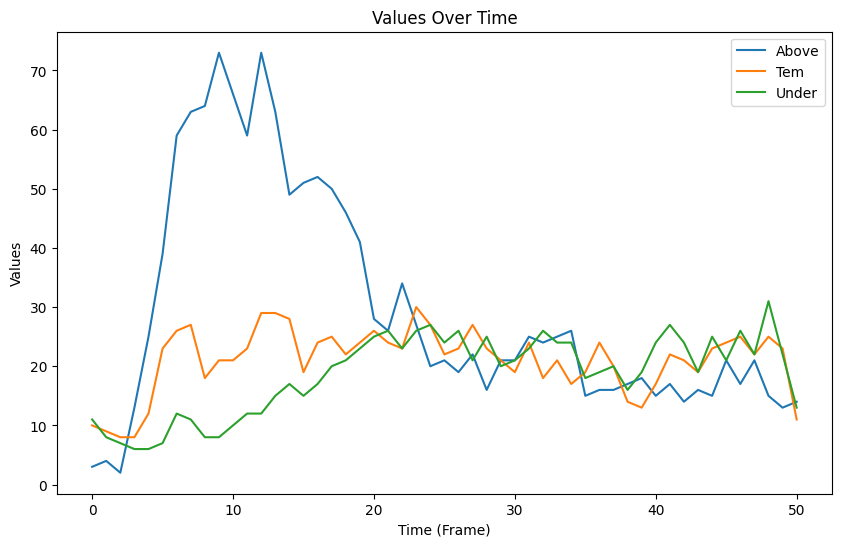

In [12]:
# @title 5. To Plot(optional)
import matplotlib.pyplot as plt

if multi:
    frames = range(len(aboves))

    # Create the plot
    plt.figure(figsize=(10, 6))  # You can adjust the figure size
    plt.plot(frames, aboves, label='Above')
    plt.plot(frames, tems, label='Tem')
    plt.plot(frames, unders, label='Under')

    # Adding title and labels
    plt.title('Values Over Time')
    plt.xlabel('Time (Frame)')
    plt.ylabel('Values')

    # Adding legend
    plt.legend()

    # Show the plot
    plt.show()
else:
    print('image does not have mutiple time frame')
